In [31]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import math
import torch
import IPython
import pandas as pd
from pyvis.network import Network
import re
import string
import numpy as np
from tqdm import tqdm
import networkx as nx
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pouri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pouri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [24]:
# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")

C:\Users\pouri\anaconda3\envs\langchain_env\Lib\site-packages\onnxruntime\capi\onnxruntime_validation.py:26: UserWarning: Unsupported Windows version (11). ONNX Runtime supports Windows 10 and above, only.
  warnings.warn(


In [25]:
def extract_relations_from_model_output(text):
    relations = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    text_replaced = text.replace("<s>", "").replace("<pad>", "").replace("</s>", "")
    for token in text_replaced.split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        relations.append({
            'head': subject.strip(),
            'type': relation.strip(),
            'tail': object_.strip()
        })
    return relations

In [26]:
class KB():
    def __init__(self):
        self.relations = []

    def are_relations_equal(self, r1, r2):
        return all(r1[attr] == r2[attr] for attr in ["head", "type", "tail"])

    def exists_relation(self, r1):
        return any(self.are_relations_equal(r1, r2) for r2 in self.relations)

    def merge_relations(self, r1):
        r2 = [r for r in self.relations
              if self.are_relations_equal(r1, r)][0]
        spans_to_add = [span for span in r1["meta"]["spans"]
                        if span not in r2["meta"]["spans"]]
        r2["meta"]["spans"] += spans_to_add

    def add_relation(self, r):
        if not self.exists_relation(r):
            self.relations.append(r)
        else:
            self.merge_relations(r)

    def print(self):
        print("Relations:")
        for r in self.relations:
            print(f"  {r}")

In [27]:
def from_text_to_kb(text, span_length=128, verbose=False):
    # tokenize whole text
    inputs = tokenizer([text], return_tensors="pt")

    # compute span boundaries
    num_tokens = len(inputs["input_ids"][0])
    if verbose:
        print(f"Input has {num_tokens} tokens")
    num_spans = math.ceil(num_tokens / span_length)
    if verbose:
        print(f"Input has {num_spans} spans")
    overlap = math.ceil((num_spans * span_length - num_tokens) /
                        max(num_spans - 1, 1))
    spans_boundaries = []
    start = 0
    for i in range(num_spans):
        spans_boundaries.append([start + span_length * i,
                                 start + span_length * (i + 1)])
        start -= overlap
    if verbose:
        print(f"Span boundaries are {spans_boundaries}")

    # transform input with spans
    tensor_ids = [inputs["input_ids"][0][boundary[0]:boundary[1]]
                  for boundary in spans_boundaries]
    tensor_masks = [inputs["attention_mask"][0][boundary[0]:boundary[1]]
                    for boundary in spans_boundaries]
    inputs = {
        "input_ids": torch.stack(tensor_ids),
        "attention_mask": torch.stack(tensor_masks)
    }

    # generate relations
    num_return_sequences = 3
    gen_kwargs = {
        "max_length": 256,
        "length_penalty": 0,
        "num_beams": 3,
        "num_return_sequences": num_return_sequences
    }
    generated_tokens = model.generate(
        **inputs,
        **gen_kwargs,
    )

    # decode relations
    decoded_preds = tokenizer.batch_decode(generated_tokens,
                                           skip_special_tokens=False)

    # create kb
    kb = KB()
    i = 0
    for sentence_pred in decoded_preds:
        current_span_index = i // num_return_sequences
        relations = extract_relations_from_model_output(sentence_pred)
        for relation in relations:
            relation["meta"] = {
                "spans": [spans_boundaries[current_span_index]]
            }
            kb.add_relation(relation)
        i += 1

    return kb

In [28]:
pcp_pattern = re.compile(r'\(PCP Entry\)(.*?)(?=\(\w+ Entry\)|$)', re.DOTALL)
specialist_pattern = re.compile(r'\(Specialist Entry\)(.*?)(?=\(\w+ Entry\)|$)', re.DOTALL)

def clean_text(text):
    text = text.strip()
    # Remove any log-like patterns within the text
    text = re.sub(r'\d{2}-\w{3}-\d{4} \d{2}:\d{2}', '', text)
    text = re.sub(r'\(.*?\):', '', text)
    text = re.sub(r'(PCP asked question|PCP Closed Request|Specialist requested referral|PCP will make referral):', '', text)
    text = re.sub(r'\n+', '\n', text).strip()

    remove_words = ['log', 'summary', 'entry']

    # List of months to be removed
    months = [
        'jan', 'feb', 'mar', 'apr', 'may', 'jun',
        'jul', 'aug', 'sep', 'oct', 'nov', 'dec'
    ]

    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    # text = text.translate(str.maketrans('', '', string.punctuation+string.digits))
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.update(remove_words)
    stop_words.update(months)

    cleaned_text = ' '.join([word for word in text.split() if word not in stop_words])

    return cleaned_text

In [6]:
df_dementia = pd.read_excel("FinalDementia2021Taxonomy_4DEC2023.xlsx", sheet_name="Data")
df_non_dementia = pd.read_excel("Urban_NonLTC_Controlx2_15DEC2023.xlsx", sheet_name="100 Urban Non LTC Control")

In [7]:
# df_dementia['Log Details'] = df_dementia['Log Details'].apply(clean_text)
# df_non_dementia['Log Detail'] = df_non_dementia['Log Detail'].apply(clean_text)
dementia_data = df_dementia['Log Details'].values
non_dementia_data = df_non_dementia['Log Detail'].values
texts = list(dementia_data)+list(non_dementia_data)

In [8]:
texts[0]

"17-Aug-2021 07:16 (Log Summary): (PCP Entry) PCP asked question: 70 yr old female living in long term care nursing home due to advanced dementia/stroke, She has long term diabetes type 2,  Last HBA1c was 11% in June 2021  EGFR is 28-30 but has gone down to 25  current DM II medications :  Linaglitin 5mg daily Metformin 500mg po BID Tresiba 75units at qch  she also has a sliding scale of tresiba which is used at meal times if needed  blood sugars average   10 in am  14 at lunch  12 at supper  9-10 at bedtime  she is on appropriate lipitor , and Blood pressure is well controlled would starting Ozempic be an option?    appreciate your advise for blood sugar control.\n17-Aug-2021 07:16 (Log Summary): (PCP Entry) eConsult created\n17-Aug-2021 08:41 (Log Summary): (Assigner Entry) eConsult assigned\n17-Aug-2021 13:59 (20Min Reason):\n17-Aug-2021 13:59 (Log Summary): (Specialist Entry) Specialist provided recommendation of: Thanks for your question.  So now that her kidney function is below 

In [9]:
# kb = [from_text_to_kb(text, verbose=False) for text in tqdm(texts)]
# # kb.print()

In [11]:
# def combine_kbs(kbs):
#     combined_kb = KB()
#     for kb in kbs:
#         for relation in kb.relations:
#             combined_kb.add_relation(relation)
#     return combined_kb


# combined_kb = combine_kbs(kb)
# combined_kb.print()


Relations:
  {'head': 'Metformin', 'type': 'medical condition treated', 'tail': 'diabetes type 2', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Metformin', 'type': 'medical condition treated', 'tail': 'long term diabetes type 2', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Tresiba', 'type': 'medical condition treated', 'tail': 'diabetes type 2', 'meta': {'spans': [[0, 128]]}}
  {'head': 'lipitor', 'type': 'medical condition treated', 'tail': 'Blood pressure', 'meta': {'spans': [[125, 253]]}}
  {'head': 'Blood pressure', 'type': 'drug used for treatment', 'tail': 'lipitor', 'meta': {'spans': [[125, 253]]}}
  {'head': 'Lipitor', 'type': 'medical condition treated', 'tail': 'Blood pressure', 'meta': {'spans': [[125, 253]]}}
  {'head': 'Tresiba', 'type': 'subclass of', 'tail': 'metformin', 'meta': {'spans': [[250, 378]]}}
  {'head': 'Tresiba', 'type': 'instance of', 'tail': 'metformin', 'meta': {'spans': [[250, 378]]}}
  {'head': 'Tresiba', 'type': 'subclass of', 'tail': 'insulin', 'meta': {'

In [10]:
import pickle

# with open("combined_kb", "wb") as f:
#     pickle.dump(combined_kb, f)

with open("combined_kb", "rb") as f:
    combined_kb = pickle.load(f)

In [11]:
def save_network_html(kb, filename="network.html"):
    # create network
    net = Network(notebook = True, directed=True,
                  width="1400px", height="700px",
                  bgcolor="#eeeeee", select_menu = True,
                  filter_menu = True, cdn_resources = "remote")

    # nodes
    color_entity = "#00FF00"
    for e in kb.relations:
        net.add_node(e['head'], shape="circle", color=color_entity)
        net.add_node(e['tail'], shape="circle", color=color_entity)

    # edges
    for r in kb.relations:
        net.add_edge(r["head"], r["tail"],
                    title=r["type"], label=r["type"])

    # save network
    net.repulsion(
        node_distance=150,
        central_gravity=0.2,
        spring_length=200,
        spring_strength=0.05,
        damping=0.09
    )
    net.set_edge_smooth('dynamic')
    net.show(filename)

In [12]:
import pickle

def save_kb(kb, filename):
    with open(filename, "wb") as f:
        pickle.dump(kb, f)

def load_kb(filename):
    res = None
    with open(filename, "rb") as f:
        res = pickle.load(f)
    return res

In [13]:
# #kb = from_urls_to_kb(news_links, verbose=True)
# filename = "network.html"
# save_network_html(combined_kb, filename=filename)
# save_kb(combined_kb, filename.split(".")[0] + ".p")
# IPython.display.HTML(filename=filename)

In [19]:
G = nx.DiGraph()
stemmer = PorterStemmer()

for relation in combined_kb.relations:
    head = stemmer.stem(relation['head'].lower())
    tail = stemmer.stem(relation['tail'].lower())
    edge_type = relation['type'].lower()
    meta = relation['meta']
    G.add_edge(head, tail, type=edge_type, meta=meta)

In [15]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)
node_degrees = nx.degree(G)

# Identify the top two nodes with the highest centrality
top_ten_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:10]

# Get neighbors of the top two nodes
neighbors = set()
for node in top_ten_nodes:
    neighbors.update(G.neighbors(node))

# Create a subgraph including the top two nodes and their neighbors
subgraph_nodes = set(top_ten_nodes).union(neighbors)
subgraph = G.subgraph(subgraph_nodes)

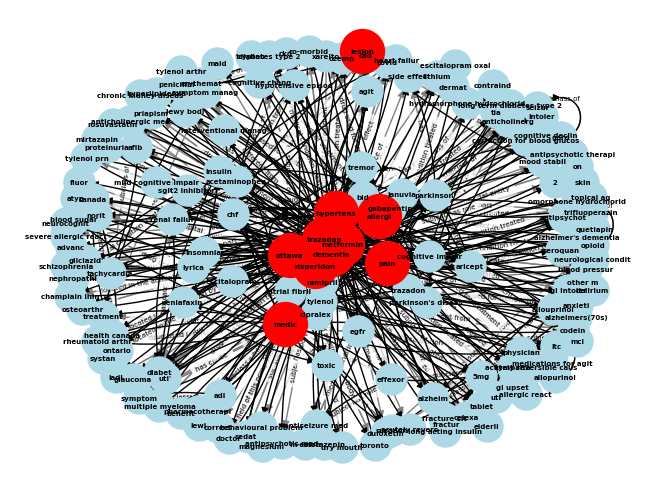

In [16]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(subgraph, k=0.8)  # You can adjust the 'k' value to spread out the nodes

# Draw the subgraph
nx.draw(subgraph, pos, with_labels=True, node_size=500, node_color="lightblue", font_size=5, font_weight="bold", edge_color="gray")

# Highlight the top node
nx.draw_networkx_nodes(subgraph, pos, nodelist=top_ten_nodes, node_color="red", node_size=1000)

# Display edge labels
edge_labels = {(u, v): d['type'] for u, v, d in subgraph.edges(data=True)}
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=5, bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

# Use curved edges for better readability
arc_edges = [(u, v) for u, v in subgraph.edges()]
nx.draw_networkx_edges(subgraph, pos, edgelist=arc_edges, connectionstyle='arc3, rad=0.1')

plt.show()

In [139]:
high_centrality_graph = KB()
for u, v, attrs in subgraph.edges(data=True):
    relation = {'head': u, 'type': attrs['type'], 'tail': v, 'meta': attrs['meta']}
    high_centrality_graph.add_relation(relation)
    

In [140]:
filename = "network_centrality.html"
save_network_html(high_centrality_graph, filename=filename)
# IPython.display.HTML(filename=filename)

network_centrality.html


In [141]:
#

In [142]:
top_keywords = {0: ['statin', 'jardiance', 'ldl', 'midodrine', 'echocardiogram', 'license', 'beats', 'meningioma', 'points', 'salt'],
                1: ['seizures', 'levodopa', 'aripiprazole', 'escitalopram', 'fibromyalgia', 'behaviour', 'antidepressant', 'mirtazapine', 'remember', 'sexual'],
                2: ['physiotherapy', 'physio', 'claudication', 'neurogenic', 'joint', 'lateral', 'emg', 'rheumatology', 'temporal', 'xrays'],
                3: ['bullae', 'seborrheic', 'plaque', 'clobetasol', 'squamous', 'pigmented', 'melanoma', 'keratotic', 'blisters', 'vasculitis'],
                4: ['colonic', 'testosterone', 'ferritin', 'enzymes', 'colitis', 'iga', 'stool', 'peg', 'lbs', 'surveillance']
               }

In [143]:
i = 0
neighbors = set()
top_topicwords = list(np.array(list(top_keywords.values())).flatten())
top_topicwords_exists = []
top_topicwords_not_exists = []
for node in top_topicwords:
    node = stemmer.stem(node)
    try:
        neighbors.update(G.neighbors(node))
        top_topicwords_exists.append(node)
    except Exception as e:
        top_topicwords_not_exists.append(node)
        i+=1
        pass

subgraph_nodes = set(top_topicwords_exists).union(neighbors)
subgraph = G.subgraph(subgraph_nodes)

In [144]:
len(top_topicwords), i

(50, 14)

In [145]:
top_topicwords_not_exists

['licens',
 'beat',
 'meningioma',
 'point',
 'rememb',
 'sexual',
 'claudic',
 'neurogen',
 'later',
 'tempor',
 'squamou',
 'pigment',
 'blister',
 'lb']

In [146]:
keyword_based_graph = KB()
for u, v, attrs in subgraph.edges(data=True):
    relation = {'head': u, 'type': attrs['type'], 'tail': v, 'meta': attrs['meta']}
    keyword_based_graph.add_relation(relation)
    

In [147]:
filename = "network_topic_keywords.html"
save_network_html(keyword_based_graph, filename=filename)
# IPython.display.HTML(filename=filename)

network_topic_keywords.html


In [148]:
for node in top_topicwords_exists:
    print(node ,": ", node_degrees[node])

statin :  10
jardianc :  8
ldl :  4
midodrin :  10
echocardiogram :  3
salt :  2
seizur :  14
levodopa :  11
aripiprazol :  9
escitalopram :  17
fibromyalgia :  19
behaviour :  4
antidepress :  7
mirtazapin :  12
physiotherapi :  4
physio :  7
joint :  2
emg :  1
rheumatolog :  10
xray :  5
bulla :  1
seborrh :  2
plaqu :  2
clobetasol :  11
melanoma :  9
keratot :  8
vascul :  6
colon :  4
testosteron :  3
ferritin :  7
enzym :  1
coliti :  1
iga :  2
stool :  4
peg :  3
surveil :  3


In [149]:
for node in top_ten_nodes:
    print(node ,": ", node_degrees[node])

medic :  106
dementia :  104
pain :  56
trazodon :  55
allergi :  55
metformin :  42
hypertens :  41
ottawa :  39
lesion :  37
risperidon :  32


In [150]:
for node in top_topicwords_exists:
    print(node ,": ", degree_centrality[node])

statin :  0.0027700831024930752
jardianc :  0.00221606648199446
ldl :  0.00110803324099723
midodrin :  0.0027700831024930752
echocardiogram :  0.0008310249307479225
salt :  0.000554016620498615
seizur :  0.003878116343490305
levodopa :  0.0030470914127423824
aripiprazol :  0.0024930747922437676
escitalopram :  0.004709141274238228
fibromyalgia :  0.005263157894736843
behaviour :  0.00110803324099723
antidepress :  0.0019390581717451524
mirtazapin :  0.00332409972299169
physiotherapi :  0.00110803324099723
physio :  0.0019390581717451524
joint :  0.000554016620498615
emg :  0.0002770083102493075
rheumatolog :  0.0027700831024930752
xray :  0.0013850415512465376
bulla :  0.0002770083102493075
seborrh :  0.000554016620498615
plaqu :  0.000554016620498615
clobetasol :  0.0030470914127423824
melanoma :  0.0024930747922437676
keratot :  0.00221606648199446
vascul :  0.001662049861495845
colon :  0.00110803324099723
testosteron :  0.0008310249307479225
ferritin :  0.0019390581717451524
enzym 

In [151]:
for node in top_ten_nodes:
    print(node ,": ", degree_centrality[node])

medic :  0.029362880886426596
dementia :  0.02880886426592798
pain :  0.01551246537396122
trazodon :  0.015235457063711913
allergi :  0.015235457063711913
metformin :  0.011634349030470914
hypertens :  0.011357340720221607
ottawa :  0.010803324099722993
lesion :  0.010249307479224378
risperidon :  0.00886426592797784


In [18]:
#

In [29]:
confusions = [204, 298, 304, 398, 67, 80, 112, 129, 179]

In [32]:
kb = [from_text_to_kb(text, verbose=False) for text in tqdm(np.array(texts)[confusions])]
# kb.print()

def combine_kbs(kbs):
    combined_kb = KB()
    for kb in kbs:
        for relation in kb.relations:
            combined_kb.add_relation(relation)
    return combined_kb


combined_kb = combine_kbs(kb)
combined_kb.print()


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:29<00:00, 16.65s/it]

Relations:
  {'head': 'Aricept', 'type': 'medical condition treated', 'tail': 'atypical chest pain', 'meta': {'spans': [[0, 128]]}}
  {'head': 'atypical chest pain', 'type': 'drug used for treatment', 'tail': 'Aricept', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Aricept', 'type': 'medical condition treated', 'tail': 'chest pain', 'meta': {'spans': [[0, 128]]}}
  {'head': 'chest pain', 'type': 'drug used for treatment', 'tail': 'Aricept', 'meta': {'spans': [[0, 128]]}}
  {'head': 'T just above 480', 'type': 'instance of', 'tail': 'ekg', 'meta': {'spans': [[87, 215]]}}
  {'head': 'T just above 480', 'type': 'point in time', 'tail': '480', 'meta': {'spans': [[87, 215]]}}
  {'head': 'PEP', 'type': 'subclass of', 'tail': 'PCP', 'meta': {'spans': [[87, 215]]}}
  {'head': 'bradycardia', 'type': 'has cause', 'tail': 'aricept', 'meta': {'spans': [[174, 302]]}}
  {'head': 'aricept', 'type': 'has effect', 'tail': 'bradycardia', 'meta': {'spans': [[174, 302]]}}
  {'head': 'bradycardia', 'type': 's

In [33]:
filename = "network_confusion.html"
save_network_html(combined_kb, filename=filename)

network_confusion.html
